<a href="https://colab.research.google.com/github/Biswamitra4599/MRI_Literature_Review/blob/main/Literature_Review_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook For Statistical Analysis on the datasets Mapping their relations and all other things

## Importing and loadings

In [1]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
# Open the Google Sheet by its name

spreadsheet_name = 'MRI Literature Reviews'
worksheet_name = 'Stats'

spreadsheet = gc.open(spreadsheet_name)
worksheet = spreadsheet.worksheet(worksheet_name)

In [4]:
# print(worksheet.get_all_values())

In [5]:
# Get all values and convert to a Pandas DataFrame
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)

df.columns = df.iloc[0]
df = df.iloc[1:]
print(df.head())

0 INDEX                                              Paper     Type  \
1     1                                            BGRAPPA  K space   
2     2  Deep learning MRI halves scan time…” — more ge...  K space   
3     3                            Zero-Shot Diffusion MRI  K space   
4     4               Diffusion Posterior Sampling for MRI  K space   
5     5  Deep Learning Superresolution for Simultaneous...  K space   

0     Model type                      Comparison Methods   Datasets Used  \
1    Statistical                                  GRAPPA       Synthetic   
2  Deep Learning                                   C-MRI  SELF Made (NA)   
3  Deep Learning  BCS, 3D-CSC, TGVNN, DLTG, DD_UGM, SSUD    OCMR Dataset   
4  Deep Learning                                                           
5  Deep Learning                                      NA       Self Made   

0     Metrics Used                                        Type of MRI  \
1     MSE, T-STATS                         

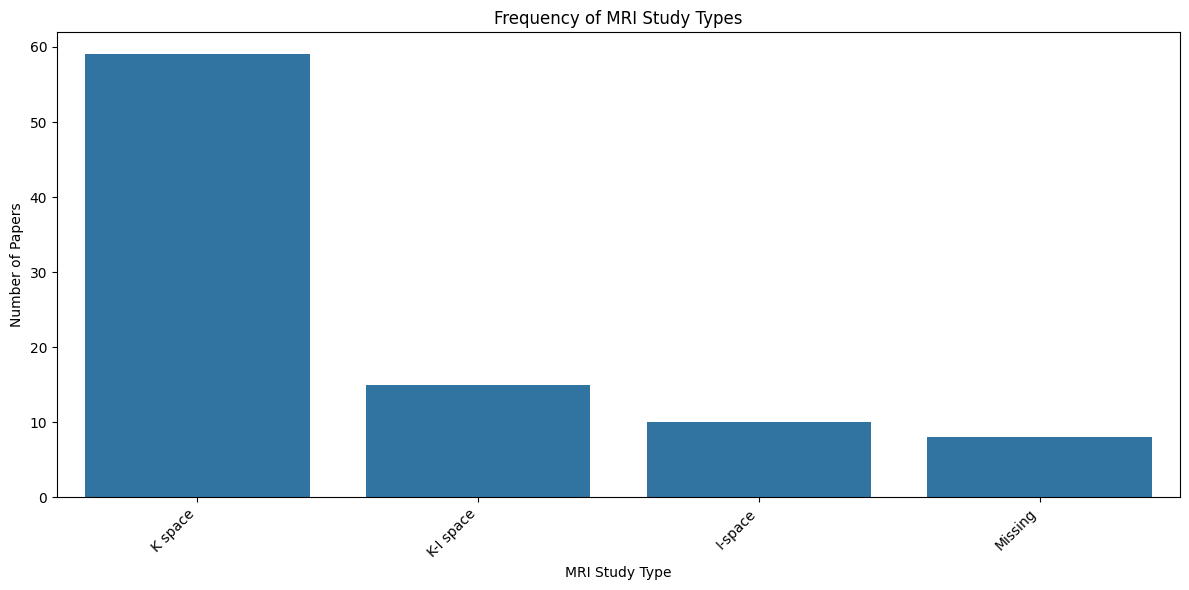

Unique MRI Study Types and their frequencies:
        Type  Frequency
0    K space         59
1  K-I space         15
2    I-space         10
3    Missing          8


In [6]:
# Replace empty strings in 'Type' column with 'Missing'
df['Type_Cleaned'] = df['Type'].replace('', 'Missing')

# Calculate frequency of each 'Type'
type_counts = df['Type_Cleaned'].value_counts().reset_index()
type_counts.columns = ['Type', 'Frequency']

# Plot the frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x='Type', y='Frequency', data=type_counts)
plt.title('Frequency of MRI Study Types')
plt.xlabel('MRI Study Type')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Unique MRI Study Types and their frequencies:")
print(type_counts)

In [7]:
import numpy as np
import re # Import the regular expression module

# 1. Define canonical model types
canonical_model_types = ['Statistical', 'Machine Learning', 'Deep Learning', 'Traditional']
all_canonical_and_missing_types = canonical_model_types + ['Missing']

# 2. Define the standardize_model_type function
def standardize_model_type(model_type_part):
    if pd.isna(model_type_part) or str(model_type_part).strip() == '':
        return 'Missing'

    part_lower = str(model_type_part).lower().strip()

    if 'deep learning' in part_lower or 'dl' == part_lower:
        return 'Deep Learning'
    elif 'machine learning' in part_lower or 'ml' == part_lower:
        return 'Machine Learning'
    elif 'statistical' in part_lower or 'stats' == part_lower:
        return 'Statistical'
    elif 'traditional' in part_lower or 'conventional' in part_lower:
        return 'Traditional'
    else:
        return 'Missing'

# 3. Define the clean_and_normalize_model_types_for_entry function
def clean_and_normalize_model_types_for_entry(entry):
    if pd.isna(entry) or str(entry).strip() == '':
        return ['Missing']

    # Split by common delimiters: comma, slash, ampersand, 'and', 'or'
    # Regex to split by ',', '/', '&', ' and ', ' or ' (case-insensitive)
    split_parts = re.split(r',|/|&|\band\b|\bor\b', str(entry), flags=re.IGNORECASE)

    cleaned_types = set()
    for part in split_parts:
        standardized = standardize_model_type(part)
        if standardized != 'Missing':
            cleaned_types.add(standardized)

    if not cleaned_types:
        return ['Missing']

    return sorted(list(cleaned_types))

# Apply the function to the 'Model type' column
df['Cleaned Model Types'] = df['Model type'].apply(clean_and_normalize_model_types_for_entry)

# Print the first 5 rows
print("Original 'Model type' and 'Cleaned Model Types' (first 5 rows):")
print(df[['Model type', 'Cleaned Model Types']].head(5))

Original 'Model type' and 'Cleaned Model Types' (first 5 rows):
0     Model type Cleaned Model Types
1    Statistical       [Statistical]
2  Deep Learning     [Deep Learning]
3  Deep Learning     [Deep Learning]
4  Deep Learning     [Deep Learning]
5  Deep Learning     [Deep Learning]



Frequency of Canonical Model Types:
      Model Type  Frequency
     Statistical          9
Machine Learning          7
   Deep Learning         55
     Traditional         20
         Missing         13


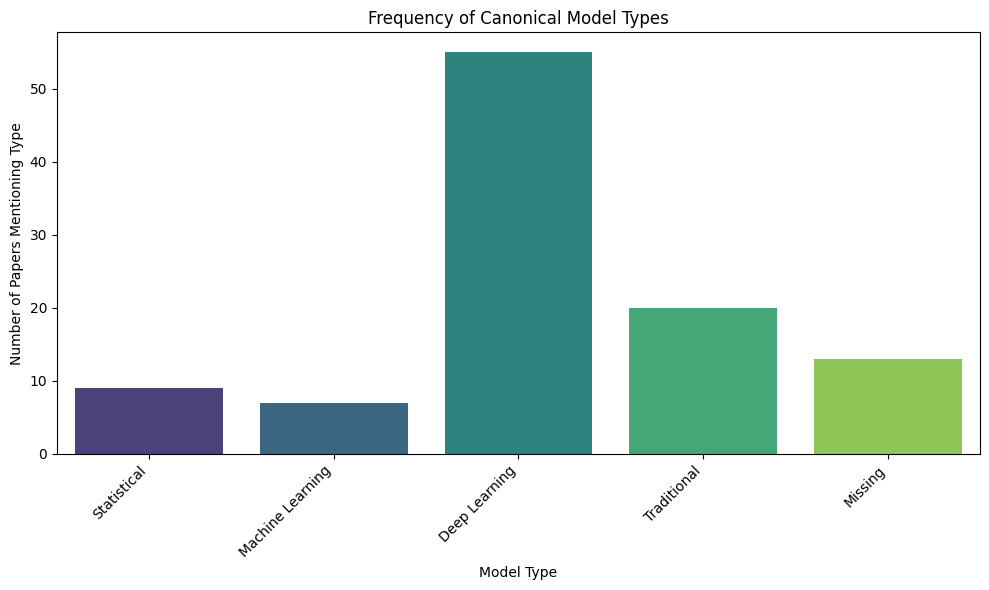

In [8]:
# 1. Flatten the list of lists in 'Cleaned Model Types'
all_model_types_flattened = pd.Series([type_ for sublist in df['Cleaned Model Types'] for type_ in sublist])

# 2. Calculate frequency of each model type and reindex
model_type_frequencies = all_model_types_flattened.value_counts().reindex(all_canonical_and_missing_types, fill_value=0)

# 3. Convert to DataFrame
model_type_frequencies_df = model_type_frequencies.reset_index()
model_type_frequencies_df.columns = ['Model Type', 'Frequency']

# 4. Print the frequency data as a table
print("\nFrequency of Canonical Model Types:")
print(model_type_frequencies_df.to_string(index=False))

# 5. Create a bar chart to visualize the frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model Type', y='Frequency', data=model_type_frequencies_df, palette='viridis', hue='Model Type', legend=False)
plt.title('Frequency of Canonical Model Types')
plt.xlabel('Model Type')
plt.ylabel('Number of Papers Mentioning Type')

# 6. Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# 7. Adjust layout
plt.tight_layout()

# 8. Display the plot
plt.show()


**Reasoning**:
The next step is to construct and visualize an overlap matrix (co-occurrence matrix) of the canonical model types, showing how many papers mention each pair. This involves initializing a matrix, populating it by iterating through the cleaned model types, printing the matrix as a table, and then visualizing it as a heatmap as described in the original problem statement.




Model Type Overlap (Co-occurrence) Matrix:
                  Statistical  Machine Learning  Deep Learning  Traditional  Missing
Statistical                 9                 1              6            1        0
Machine Learning            1                 7              3            1        0
Deep Learning               6                 3             55            2        0
Traditional                 1                 1              2           20        0
Missing                     0                 0              0            0       13


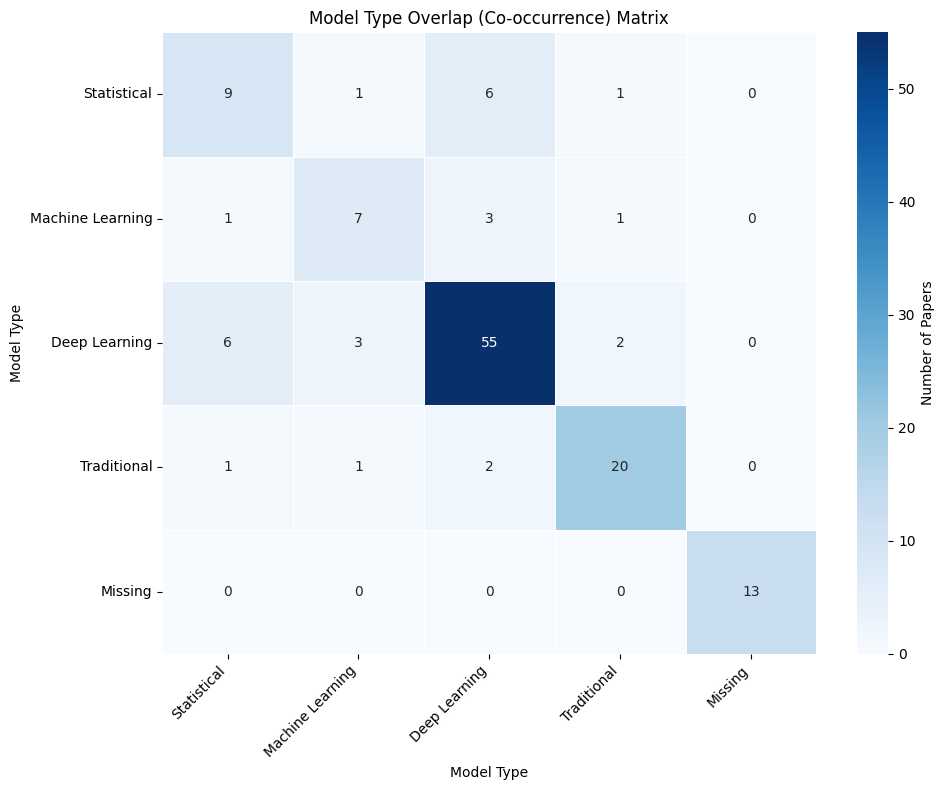

In [9]:
# Initialize the co-occurrence matrix as a DataFrame, with all canonical types as index and columns
num_types = len(all_canonical_and_missing_types)
co_occurrence_matrix = pd.DataFrame(
    np.zeros((num_types, num_types), dtype=int),
    index=all_canonical_and_missing_types,
    columns=all_canonical_and_missing_types
)

# Populate the co-occurrence matrix
for model_types_list in df['Cleaned Model Types']:
    # Iterate through each unique type in the current paper's list
    for type1 in model_types_list:
        # Increment self-co-occurrence for the type
        co_occurrence_matrix.loc[type1, type1] += 1
        # Iterate through all other types in the list to count cross-co-occurrences
        for type2 in model_types_list:
            if type1 != type2: # Avoid double-counting self-occurrence here
                co_occurrence_matrix.loc[type1, type2] += 1

# Print the overlap matrix as a table
print("\nModel Type Overlap (Co-occurrence) Matrix:")
print(co_occurrence_matrix.to_string())

# Visualize the overlap matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={'label': 'Number of Papers'})
plt.title('Model Type Overlap (Co-occurrence) Matrix')
plt.xlabel('Model Type')
plt.ylabel('Model Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# 1. Rename the column 'Year ' to 'Year' by stripping any trailing spaces
df.rename(columns={'Year ': 'Year'}, inplace=True)

# 2. Convert the 'Year' column to a numeric data type, coercing non-numeric values to NaN
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# 3. Display the first few rows of the DataFrame showing the updated 'Year' column
print("First 5 rows of DataFrame with cleaned 'Year' column:")
print(df[['Year']].head())

First 5 rows of DataFrame with cleaned 'Year' column:
0  Year
1  2025
2  2025
3  2025
4  2025
5  2025


In [11]:
print(df.head())

0 INDEX                                              Paper     Type  \
1     1                                            BGRAPPA  K space   
2     2  Deep learning MRI halves scan time…” — more ge...  K space   
3     3                            Zero-Shot Diffusion MRI  K space   
4     4               Diffusion Posterior Sampling for MRI  K space   
5     5  Deep Learning Superresolution for Simultaneous...  K space   

0     Model type                      Comparison Methods   Datasets Used  \
1    Statistical                                  GRAPPA       Synthetic   
2  Deep Learning                                   C-MRI  SELF Made (NA)   
3  Deep Learning  BCS, 3D-CSC, TGVNN, DLTG, DD_UGM, SSUD    OCMR Dataset   
4  Deep Learning                                                           
5  Deep Learning                                      NA       Self Made   

0     Metrics Used                                        Type of MRI  \
1     MSE, T-STATS                         

In [12]:

# 1. Create a new DataFrame by exploding the 'Cleaned Model Types' column
df_exploded = df.explode('Cleaned Model Types')

# 2. Group the new DataFrame by 'Year' and the exploded 'Cleaned Model Types', and count the occurrences
year_model_trends = df_exploded.groupby(['Year', 'Cleaned Model Types']).size().reset_index()

# Rename the column containing the counts to 'Count'
year_model_trends.columns = ['Year', 'Model Type', 'Count']

# Handle potential missing year-model type combinations by reindexing
# Get all unique years from the original DataFrame (after cleaning)
all_years = sorted(df['Year'].dropna().unique().astype(int))

# Create a MultiIndex with all combinations of years and canonical model types
multi_index = pd.MultiIndex.from_product([all_years, all_canonical_and_missing_types], names=['Year', 'Model Type'])

# Reindex the year_model_trends DataFrame to include all combinations, filling missing with 0
year_model_trends_full = year_model_trends.set_index(['Year', 'Model Type']).reindex(multi_index, fill_value=0).reset_index()

# Print the head of the resulting DataFrame
print("Head of year-wise model type trends DataFrame:")
print(year_model_trends_full.head(10))

Head of year-wise model type trends DataFrame:
   Year        Model Type  Count
0  1997       Statistical      0
1  1997  Machine Learning      0
2  1997     Deep Learning      0
3  1997       Traditional      1
4  1997           Missing      0
5  1998       Statistical      0
6  1998  Machine Learning      0
7  1998     Deep Learning      0
8  1998       Traditional      1
9  1998           Missing      0


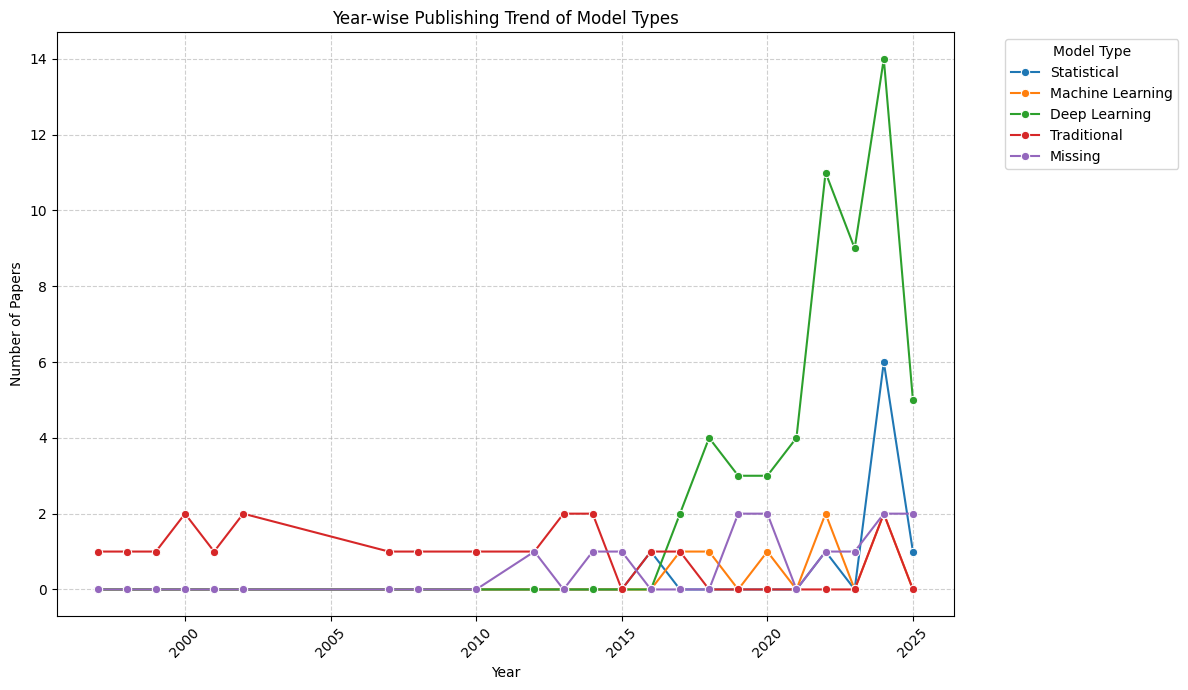

In [13]:
# Create the line plot
plt.figure(figsize=(12, 7))
sns.lineplot(data=year_model_trends_full, x='Year', y='Count', hue='Model Type', marker='o')

plt.title('Year-wise Publishing Trend of Model Types')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [14]:
df_type_encoded = pd.get_dummies(df['Type_Cleaned'], prefix='Type', dtype=int)
print("First 5 rows of One-Hot Encoded 'Type_Cleaned' column:")
print(df_type_encoded.head())

First 5 rows of One-Hot Encoded 'Type_Cleaned' column:
   Type_I-space  Type_K space  Type_K-I space  Type_Missing
1             0             1               0             0
2             0             1               0             0
3             0             1               0             0
4             0             1               0             0
5             0             1               0             0


**Reasoning**:
Next, I will use `MultiLabelBinarizer` to perform multi-hot encoding on the 'Cleaned Model Types' column, as it contains lists of model types, and this is required to represent multiple categories per paper numerically for clustering.



In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_model_encoded = pd.DataFrame(mlb.fit_transform(df['Cleaned Model Types']),
                                  columns=mlb.classes_,
                                  index=df.index)
print("First 5 rows of Multi-Hot Encoded 'Cleaned Model Types' column:")
print(df_model_encoded.head())

First 5 rows of Multi-Hot Encoded 'Cleaned Model Types' column:
   Deep Learning  Machine Learning  Missing  Statistical  Traditional
1              0                 0        0            1            0
2              1                 0        0            0            0
3              1                 0        0            0            0
4              1                 0        0            0            0
5              1                 0        0            0            0


**Reasoning**:
Now, I will create a copy of the 'Year' column, fill any missing values with its median, and then scale it using `StandardScaler` to normalize its range, which is essential for distance-based clustering algorithms.



In [16]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the 'Year' column
df_year_cleaned = df['Year'].copy()

# Fill NaN values with the median year
median_year = df_year_cleaned.median()
df_year_cleaned.fillna(median_year, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the cleaned 'Year' column (reshaped to 2D)
df_year_scaled = pd.DataFrame(scaler.fit_transform(df_year_cleaned.values.reshape(-1, 1)),
                                columns=['Year_Scaled'],
                                index=df.index)

print("First 5 rows of Scaled 'Year' column:")
print(df_year_scaled.head())

First 5 rows of Scaled 'Year' column:
   Year_Scaled
1     0.889399
2     0.889399
3     0.889399
4     0.889399
5     0.889399


**Reasoning**:
Now that 'Type_Cleaned' and 'Cleaned Model Types' have been encoded, and the 'Year' column has been scaled, I will combine these three processed DataFrames into a single feature matrix using `pd.concat()` to prepare for hierarchical clustering.



In [17]:
feature_matrix = pd.concat([df_type_encoded, df_model_encoded, df_year_scaled], axis=1)

print("Shape of the final feature matrix:", feature_matrix.shape)
print("First 5 rows of the feature matrix:")
print(feature_matrix.head())

Shape of the final feature matrix: (92, 10)
First 5 rows of the feature matrix:
   Type_I-space  Type_K space  Type_K-I space  Type_Missing  Deep Learning  \
1             0             1               0             0              0   
2             0             1               0             0              1   
3             0             1               0             0              1   
4             0             1               0             0              1   
5             0             1               0             0              1   

   Machine Learning  Missing  Statistical  Traditional  Year_Scaled  
1                 0        0            1            0     0.889399  
2                 0        0            0            0     0.889399  
3                 0        0            0            0     0.889399  
4                 0        0            0            0     0.889399  
5                 0        0            0            0     0.889399  


## Perform Hierarchical Clustering

### Subtask:
Apply hierarchical clustering (e.g., Agglomerative Clustering) on the prepared feature matrix using an appropriate linkage method. Calculate the linkage matrix for dendrogram visualization.


**Reasoning**:
To perform hierarchical clustering and obtain the linkage matrix for dendrogram visualization, I will import the `linkage` function from `scipy.cluster.hierarchy` and apply it to the `feature_matrix` using the 'ward' linkage method.



In [18]:
from scipy.cluster.hierarchy import linkage

# Apply hierarchical clustering using the 'ward' linkage method
linked_data = linkage(feature_matrix, method='ward')

print("Shape of the linkage matrix:", linked_data.shape)
print("First 5 rows of the linkage matrix:\n", linked_data[:5])

Shape of the linkage matrix: (91, 4)
First 5 rows of the linkage matrix:
 [[11. 13.  0.  2.]
 [ 1.  2.  0.  2.]
 [ 3. 93.  0.  3.]
 [ 4. 94.  0.  4.]
 [ 5. 95.  0.  5.]]


In [19]:
# Install UpSetPlot library if not already installed
!pip install upsetplot


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=81705aa83813799c268e362869529441c52daf86454e3d05e48e8ca73a2d9b69
  Stored in directory: /root/.cache/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built upsetplot


/usr/local/lib/python3.12/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.12/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

<Figure size 1200x600 with 0 Axes>

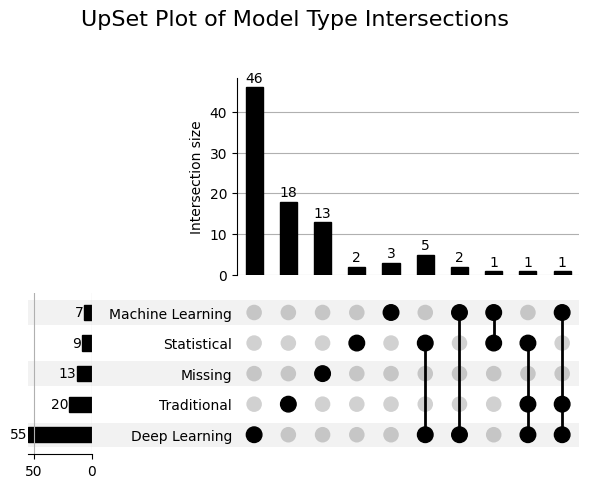

In [20]:
from upsetplot import plot
import matplotlib.pyplot as plt

# The df_model_encoded DataFrame already contains the multi-hot encoded data
# We need to ensure the columns are boolean type for UpSetPlot
df_model_encoded_bool = df_model_encoded.astype(bool)

# Group by all boolean columns to get the count of each unique combination
# This creates a Series with a unique MultiIndex representing the set combinations
data_for_upset_plot = df_model_encoded_bool.groupby(list(df_model_encoded_bool.columns)).size()

plt.figure(figsize=(12, 6))
# Create the UpSet plot
plot(data_for_upset_plot, sort_by='degree', show_counts=True)
plt.suptitle('UpSet Plot of Model Type Intersections', y=1.02, fontsize=16)
plt.show()

# Task
```python
import re

# 1. Define canonical body parts (optional, but good for standardization if a fixed list is known)
# For now, we'll let unique parts emerge naturally and then review for canonicalization.
# If a fixed list were available, it would be here: canonical_body_parts = ['Brain', 'Spine', ...]

# 2. Define a function to standardize individual body part entries
def standardize_body_part(part_entry):
    if pd.isna(part_entry) or str(part_entry).strip() == '':
        return 'Missing'
    part_lower = str(part_entry).lower().strip()
    # Simple canonicalization based on common terms
    if 'brain' in part_lower:
        return 'Brain'
    elif 'spine' in part_lower:
        return 'Spine'
    elif 'cardiac' in part_lower or 'heart' in part_lower:
        return 'Cardiac'
    elif 'knee' in part_lower:
        return 'Knee'
    elif 'mussel' in part_lower or 'muscle' in part_lower:
        return 'Muscle' # Correcting "Mussles" typo to "Muscle"
    elif 'liver' in part_lower:
        return 'Liver'
    elif 'abdominal' in part_lower or 'abdomen' in part_lower:
        return 'Abdomen'
    elif 'breast' in part_lower:
        return 'Breast'
    elif 'prostate' in part_lower:
        return 'Prostate'
    elif 'eye' in part_lower:
        return 'Eye'
    elif 'kidney' in part_lower:
        return 'Kidney'
    elif 'cervical' in part_lower:
        return 'Cervical'
    elif 'lungs' in part_lower:
        return 'Lungs'
    elif 'fetus' in part_lower:
        return 'Fetus'
    elif 'others' in part_lower:
        return 'Others'
    elif 'limb' in part_lower:
        return 'Limb'
    elif 'head' in part_lower:
        return 'Head'
    elif 'bone' in part_lower:
        return 'Bone'
    elif 'wrist' in part_lower:
        return 'Wrist'
    elif 'carotid' in part_lower:
        return 'Carotid'
    # Add more as needed based on data exploration
    else:
        return 'Other Specific Body Part' # Catch-all for less common but specific parts

# 3. Define the cleaning and normalization function for the 'Body Parts' column
def clean_and_normalize_body_parts_for_entry(entry):
    if pd.isna(entry) or str(entry).strip() == '':
        return ['Missing']

    # Split by common delimiters: comma, slash, ampersand, 'and', 'or', semicolon
    # Use re.IGNORECASE for 'and'/'or'
    split_parts = re.split(r',|/|&|\band\b|\bor\b|;', str(entry), flags=re.IGNORECASE)

    cleaned_parts = set()
    for part in split_parts:
        standardized = standardize_body_part(part)
        if standardized != 'Missing': # Only add if it's not a 'Missing' value from standardization
            cleaned_parts.add(standardized)

    if not cleaned_parts: # If after splitting and standardizing, nothing remains, treat as 'Missing'
        return ['Missing']

    return sorted(list(cleaned_parts))

# Apply the function to the 'Body Parts' column
df['Cleaned Body Parts'] = df['Body Parts'].apply(clean_and_normalize_body_parts_for_entry)

# Print the original 'Body Parts' and the new 'Cleaned Body Parts' columns for inspection
print("Original 'Body Parts' and 'Cleaned Body Parts' (first 10 rows):")
print(df[['Body Parts', 'Cleaned Body Parts']].head(10).to_string())

# Display unique cleaned body parts to check for further canonicalization needs
all_cleaned_body_parts = [item for sublist in df['Cleaned Body Parts'] for item in sublist]
unique_cleaned_body_parts = sorted(list(set(all_cleaned_body_parts)))
print("\nUnique cleaned Body Parts found:")
print(unique_cleaned_body_parts)
```

## Prepare 'Body Parts' data

### Subtask:
Clean and normalize the 'Body Parts' column. This includes splitting multiple entries by common delimiters, stripping whitespace, and treating empty entries as 'Missing'. The unique body parts will be extracted and canonicalized implicitly.


**Reasoning**:
I will define two functions to clean and normalize the 'Body Parts' column: `standardize_body_part` for individual entries and `clean_and_normalize_body_parts_for_entry` for processing entire cells, which handles splitting by delimiters, standardizing, and managing missing values. Then, I'll apply these functions to create a new 'Cleaned Body Parts' column, display the first 10 rows for verification, and finally extract and print all unique cleaned body parts.



In [21]:
import re # Import the regular expression module

# 1. Define the standardize_body_part function
def standardize_body_part(part):
    if pd.isna(part) or str(part).strip() == '':
        return 'Missing'
    part_lower = str(part).lower().strip()
    if 'brain' in part_lower:
        return 'Brain'
    elif 'spine' in part_lower:
        return 'Spine'
    elif 'knee' in part_lower:
        return 'Knee'
    elif 'cardiac' in part_lower or 'heart' in part_lower:
        return 'Cardiac'
    elif 'mussles' in part_lower or 'muscles' in part_lower:
        return 'Muscles'
    elif 'prostate' in part_lower:
        return 'Prostate'
    elif 'liver' in part_lower:
        return 'Liver'
    elif 'breast' in part_lower:
        return 'Breast'
    elif 'others' in part_lower or 'other' in part_lower:
        return 'Other'
    else:
        return 'Missing'

# 2. Define the clean_and_normalize_body_parts_for_entry function
def clean_and_normalize_body_parts_for_entry(entry):
    if pd.isna(entry) or str(entry).strip() == '':
        return ['Missing']

    # Split by common delimiters: comma, slash, ampersand, 'and', 'or', newline
    split_parts = re.split(r',|/|&|\band\b|\bor\b|\n', str(entry), flags=re.IGNORECASE)

    cleaned_parts = set()
    for part in split_parts:
        standardized = standardize_body_part(part)
        if standardized != 'Missing':
            cleaned_parts.add(standardized)

    if not cleaned_parts:
        return ['Missing']

    return sorted(list(cleaned_parts))

# 3. Apply the function to the 'Body Parts' column
df['Cleaned Body Parts'] = df['Body Parts'].apply(clean_and_normalize_body_parts_for_entry)

# 4. Print the first 10 rows of the 'Body Parts' and 'Cleaned Body Parts' columns
print("First 10 rows of 'Body Parts' and 'Cleaned Body Parts':")
print(df[['Body Parts', 'Cleaned Body Parts']].head(10))

# 5. Extract all unique cleaned body parts
all_cleaned_body_parts_flattened = pd.Series([part for sublist in df['Cleaned Body Parts'] for part in sublist])
unique_cleaned_body_parts = sorted(all_cleaned_body_parts_flattened.unique())

# 6. Print the list of unique cleaned body parts found
print("\nUnique Cleaned Body Parts found:")
print(unique_cleaned_body_parts)

First 10 rows of 'Body Parts' and 'Cleaned Body Parts':
0                             Body Parts                    Cleaned Body Parts
1                                  Brain                               [Brain]
2   Brain, Spine, Mussles,  Others, Knee  [Brain, Knee, Muscles, Other, Spine]
3                                Cardiac                             [Cardiac]
4                                                                    [Missing]
5                                   Knee                                [Knee]
6                                  Brain                               [Brain]
7                                                                    [Missing]
8                                                                    [Missing]
9                                  Brain                               [Brain]
10                                 Brain                               [Brain]

Unique Cleaned Body Parts found:
['Brain', 'Cardiac', 'Knee', 'Missing', '

## Plot frequency of Body Parts

### Subtask:
Calculate the frequency of each unique body part (including 'Missing' entries) and visualize these frequencies using a bar chart. Also, print the frequency data as a table.


**Reasoning**:
To visualize the frequency of each unique body part, I will calculate the value counts of the 'all_cleaned_body_parts_flattened' Series, reindex it to ensure all unique body parts are represented, convert it to a DataFrame, print the DataFrame, and then create a bar chart with appropriate labels and title.




Frequency of Cleaned Body Parts:
Body Part  Frequency
    Brain         57
  Cardiac         15
     Knee         17
  Missing         17
  Muscles          1
    Other          4
 Prostate          1
    Spine          1


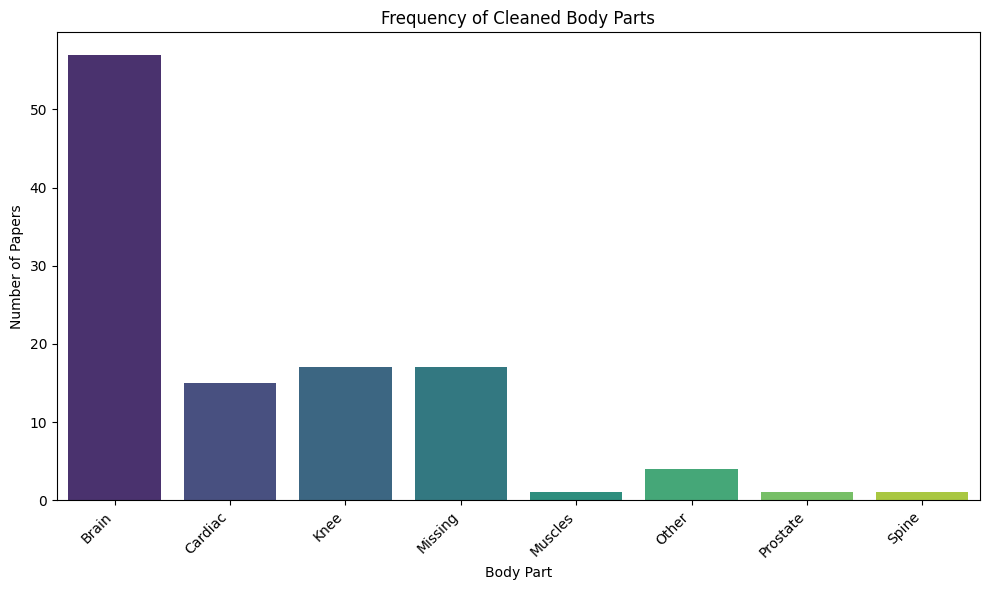

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate frequency of each body part and reindex
body_part_frequencies = all_cleaned_body_parts_flattened.value_counts().reindex(unique_cleaned_body_parts, fill_value=0)

# 2. Convert to DataFrame
body_part_frequencies_df = body_part_frequencies.reset_index()
body_part_frequencies_df.columns = ['Body Part', 'Frequency']

# 3. Print the frequency data as a table
print("\nFrequency of Cleaned Body Parts:")
print(body_part_frequencies_df.to_string(index=False))

# 4. Create a bar chart to visualize the frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x='Body Part', y='Frequency', data=body_part_frequencies_df, palette='viridis', hue='Body Part', legend=False)

# 5. Add a title to the plot
plt.title('Frequency of Cleaned Body Parts')

# 6. Label the x-axis and y-axis
plt.xlabel('Body Part')
plt.ylabel('Number of Papers')

# 7. Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# 8. Adjust layout
plt.tight_layout()

# 9. Display the plot
plt.show()


Body Parts Overlap (Co-occurrence) Matrix:
          Brain  Cardiac  Knee  Missing  Muscles  Other  Prostate  Spine
Brain        57        5    11        0        1      2         1      1
Cardiac       5       15     0        0        0      0         0      0
Knee         11        0    17        0        1      2         0      1
Missing       0        0     0       17        0      0         0      0
Muscles       1        0     1        0        1      1         0      1
Other         2        0     2        0        1      4         0      1
Prostate      1        0     0        0        0      0         1      0
Spine         1        0     1        0        1      1         0      1


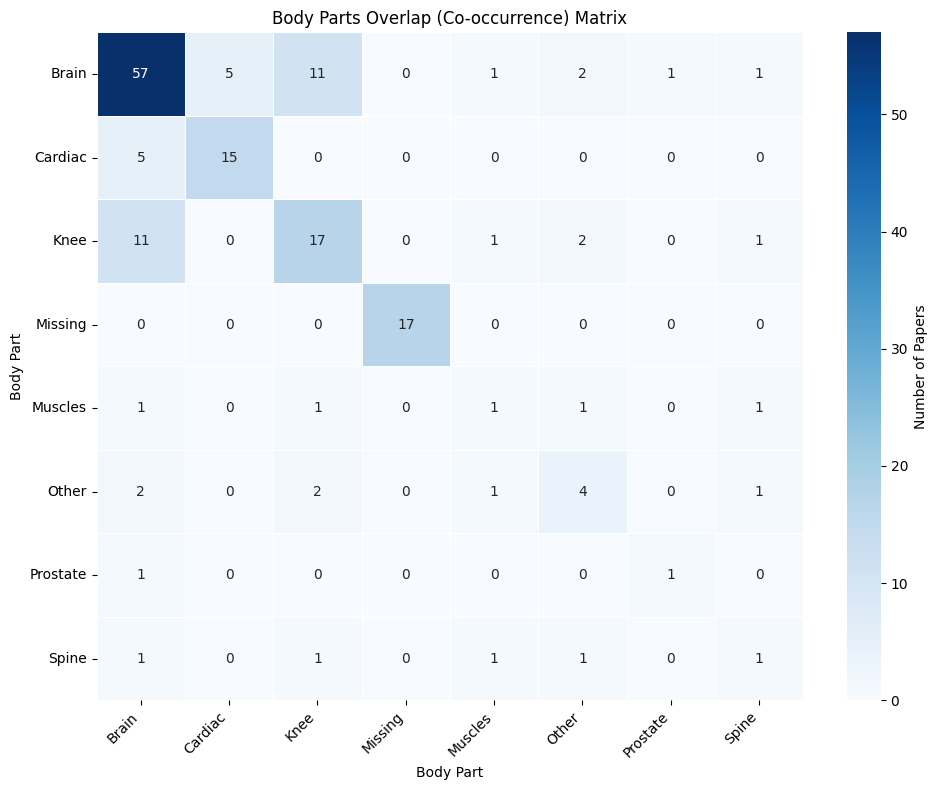

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the co-occurrence matrix as a DataFrame
# Use unique_cleaned_body_parts as both index and columns
num_body_parts = len(unique_cleaned_body_parts)
co_occurrence_matrix_body_parts = pd.DataFrame(
    np.zeros((num_body_parts, num_body_parts), dtype=int),
    index=unique_cleaned_body_parts,
    columns=unique_cleaned_body_parts
)

# Populate the co-occurrence matrix
for body_parts_list in df['Cleaned Body Parts']:
    for part1 in body_parts_list:
        # Increment self-co-occurrence
        co_occurrence_matrix_body_parts.loc[part1, part1] += 1
        # Increment cross-co-occurrences
        for part2 in body_parts_list:
            if part1 != part2:
                co_occurrence_matrix_body_parts.loc[part1, part2] += 1

# Print the overlap matrix as a table
print("\nBody Parts Overlap (Co-occurrence) Matrix:")
print(co_occurrence_matrix_body_parts.to_string())

# Visualize the overlap matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix_body_parts, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={'label': 'Number of Papers'})
plt.title('Body Parts Overlap (Co-occurrence) Matrix')
plt.xlabel('Body Part')
plt.ylabel('Body Part')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Task
Prepare the data for an alluvial plot by exploding the 'Cleaned Body Parts' column and then combining it with 'Type_Cleaned' to count occurrences, ensuring the data is in a suitable format for visualization.

## Prepare Data for Alluvial Plot

### Subtask:
Create a DataFrame suitable for an alluvial plot by combining the 'Type_Cleaned' and 'Cleaned Body Parts' columns.


**Reasoning**:
To prepare the data for an alluvial plot, I will explode the 'Cleaned Body Parts' column, merge it with 'Type_Cleaned', then group and count the occurrences of each unique combination, and finally rename the columns for clarity.



In [24]:
import pandas as pd

# 1. Create a new DataFrame by exploding the 'Cleaned Body Parts' column
df_body_parts_exploded = df.explode('Cleaned Body Parts')

# 2. Merge this new exploded DataFrame with the 'Type_Cleaned' column from the original df
# We'll select 'Type_Cleaned' from df_body_parts_exploded since it already has the correct index due to explode
df_alluvial_prep = df_body_parts_exploded[['Type_Cleaned', 'Cleaned Body Parts']]

# 3. Group the merged DataFrame by 'Type_Cleaned' and 'Cleaned Body Parts'
# 4. Count the occurrences for each unique combination
df_alluvial_grouped = df_alluvial_prep.groupby(['Type_Cleaned', 'Cleaned Body Parts']).size().reset_index()

# 5. Rename the columns
df_alluvial_grouped.columns = ['Type', 'Body Part', 'Count']

print("First 10 rows of the DataFrame prepared for alluvial plot:")
print(df_alluvial_grouped.head(10))

First 10 rows of the DataFrame prepared for alluvial plot:
      Type Body Part  Count
0  I-space     Brain      7
1  I-space   Cardiac      3
2  I-space   Missing      2
3  K space     Brain     36
4  K space   Cardiac     11
5  K space      Knee     10
6  K space   Missing     11
7  K space   Muscles      1
8  K space     Other      3
9  K space  Prostate      1


## Generate Alluvial Plot

### Subtask:
Generate an alluvial plot using the prepared data to visualize the flow and connections between MRI study types and the body parts they investigate.


In [25]:
# Install pyalluvial if not already installed
!pip install pyalluvial


AttributeError: module 'pyalluvial' has no attribute 'alluvial'

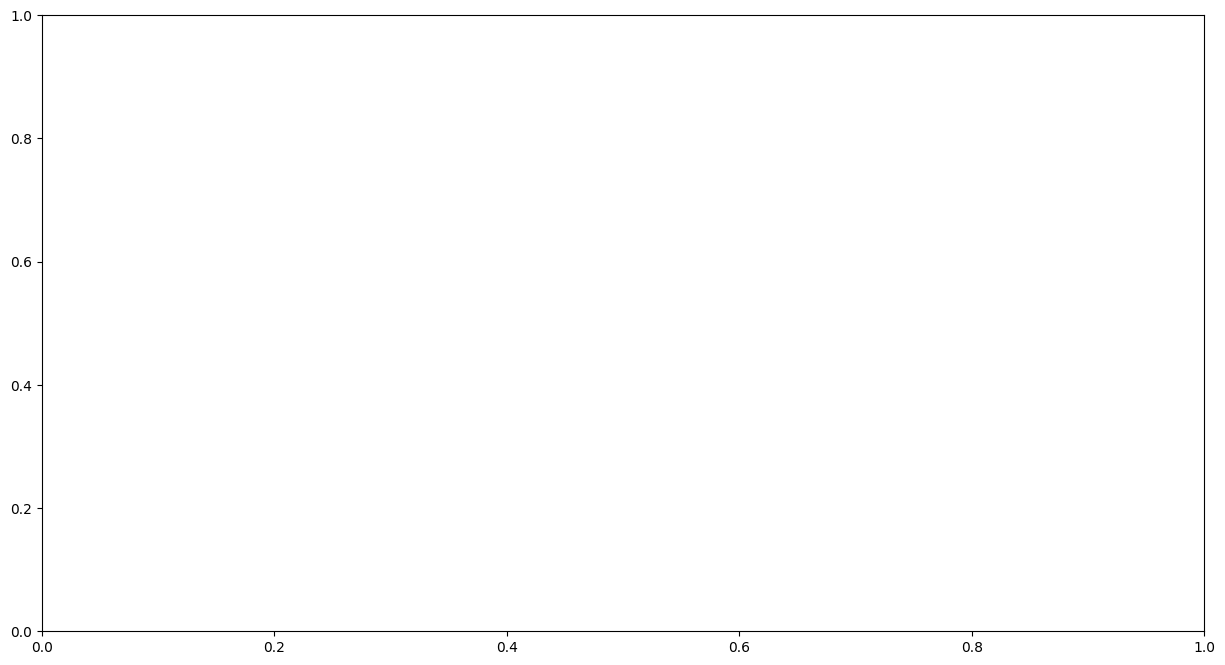

In [36]:
import matplotlib.pyplot as plt
import pyalluvial # Import the entire pyalluvial package

# Create the alluvial plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)

# Call the alluvial plotting function, which is likely pyalluvial.alluvial
pyalluvial.alluvial(
    sankey_data=df_alluvial_grouped, # Pass the DataFrame as 'sankey_data'
    x_axis_names=['Type', 'Body Part'], # Columns for the x-axis categories
    y_name='Count', # Column for the flow quantity
    # alluvium=None, # This is an optional argument for coloring; omitting for now to simplify
    ax=ax, # Pass the axes object
    kw_label={'size': 12},
    kw_river={'alpha': 0.6, 'width': 0.4},
    kw_flow={'alpha': 0.6}
)

plt.title('Alluvial Plot: MRI Study Type to Body Part Investigation', fontsize=16)
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import plotly.graph_objects as go


# ----------------------------------------
# Normalize Missing Values per column
# ----------------------------------------
def normalize_missing(value, colname):
    if value == "Missing":
        return f"Missing ({colname})"
    return value


def normalize_list_column(items, colname):
    if not isinstance(items, list):
        items = [items]

    new_items = []
    for x in items:
        if x == "Missing":
            new_items.append(f"Missing ({colname})")
        else:
            new_items.append(x)
    return new_items


# ----------------------------------------
# Explode pairs safely
# ----------------------------------------
def explode_pairs(df, colA, colB):
    rows = []
    for _, row in df.iterrows():
        left = normalize_missing(row[colA], colA)
        right_items = normalize_list_column(row[colB], colB)

        for r in right_items:
            rows.append((left, r))

    return pd.DataFrame(rows, columns=["source", "target"])


# ----------------------------------------
# Build an Alluvial (Sankey) Plot
# ----------------------------------------
def make_alluvial(df_pairs, title):
    sources = df_pairs["source"].astype(str)
    targets = df_pairs["target"].astype(str)

    combined = pd.concat([sources, targets], ignore_index=True)
    labels = list(pd.unique(combined))

    label_id = {label: i for i, label in enumerate(labels)}
    source_ids = sources.map(label_id).tolist()
    target_ids = targets.map(label_id).tolist()

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(width=1),
            label=labels,
        ),
        link=dict(
            source=source_ids,
            target=target_ids,
            value=[1] * len(source_ids)
        )
    )])

    fig.update_layout(title_text=title, font_size=12)
    fig.show()


# ============================================================
# 1) Type_Cleaned ↔ Cleaned Model Types
# ============================================================
pairs_1 = explode_pairs(df, "Type_Cleaned", "Cleaned Model Types")
make_alluvial(pairs_1, "Type_Cleaned ↔ Cleaned Model Types")


# ============================================================
# 2) Type_Cleaned ↔ Cleaned Body Parts
# ============================================================
pairs_2 = explode_pairs(df, "Type_Cleaned", "Cleaned Body Parts")
make_alluvial(pairs_2, "Type_Cleaned ↔ Cleaned Body Parts")


# ============================================================
# 3) Cleaned Model Types ↔ Cleaned Body Parts (both lists)
# ============================================================
rows = []
for _, row in df.iterrows():
    l_list = normalize_list_column(row["Cleaned Model Types"], "Cleaned Model Types")
    r_list = normalize_list_column(row["Cleaned Body Parts"], "Cleaned Body Parts")

    for L in l_list:
        for R in r_list:
            rows.append((L, R))

pairs_3 = pd.DataFrame(rows, columns=["source", "target"])
make_alluvial(pairs_3, "Cleaned Model Types ↔ Cleaned Body Parts")


In [37]:
import pandas as pd
import plotly.graph_objects as go

# ---------------------------------------------------------
# Fix the "Missing" entries uniquely per column
# ---------------------------------------------------------
def fix_missing(df):
    df = df.copy()

    df["Type_Cleaned"] = df["Type_Cleaned"].replace("Missing", "Missing (Type)")

    df["Cleaned Model Types"] = df["Cleaned Model Types"].apply(
        lambda x: ["Missing (Model)"] if x == "Missing" or x == [] else x
    )

    df["Cleaned Body Parts"] = df["Cleaned Body Parts"].apply(
        lambda x: ["Missing (Body)"] if x == "Missing" or x == [] else x
    )

    return df


# ---------------------------------------------------------
# Explode a column pair into weighted source-target pairs
# ---------------------------------------------------------
def explode_pairs(df, colA, colB):
    rows = []

    for _, row in df.iterrows():
        left = row[colA]
        right_items = row[colB]

        if not isinstance(right_items, list):
            right_items = [right_items]

        for r in right_items:
            rows.append((left, r))

    df_pairs = pd.DataFrame(rows, columns=["source", "target"])

    # ✔ Add WEIGHTS by counting duplicates
    df_weighted = df_pairs.groupby(["source", "target"]).size().reset_index(name="weight")
    return df_weighted


# ---------------------------------------------------------
# Build weighted alluvial (Sankey) in plotly
# ---------------------------------------------------------
def make_alluvial(df_pairs, title):
    sources = df_pairs["source"].astype(str)
    targets = df_pairs["target"].astype(str)
    weights = df_pairs["weight"]

    # Create unified label set
    combined = pd.concat([sources, targets], ignore_index=True)
    labels = list(pd.unique(combined))

    # Map labels → indices
    label_index = {label: i for i, label in enumerate(labels)}

    source_ids = sources.map(label_index).tolist()
    target_ids = targets.map(label_index).tolist()

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            label=labels,
            line=dict(width=1),
        ),
        link=dict(
            source=source_ids,
            target=target_ids,
            value=weights.tolist()   # ✔ weighted connections
        )
    )])

    fig.update_layout(title_text=title, font_size=12)
    fig.show()


# =========================================================
#                APPLY EVERYTHING
# =========================================================
df = fix_missing(df)

# 1) Type_Cleaned → Cleaned Model Types
pairs_1 = explode_pairs(df, "Type_Cleaned", "Cleaned Model Types")
make_alluvial(pairs_1, "Type_Cleaned ↔ Cleaned Model Types (Weighted)")

# 2) Type_Cleaned → Cleaned Body Parts
pairs_2 = explode_pairs(df, "Type_Cleaned", "Cleaned Body Parts")
make_alluvial(pairs_2, "Type_Cleaned ↔ Cleaned Body Parts (Weighted)")

# 3) Cleaned Model Types → Cleaned Body Parts (both list columns)
rows = []
for _, row in df.iterrows():
    left_list = row["Cleaned Model Types"]
    right_list = row["Cleaned Body Parts"]

    if not isinstance(left_list, list):
        left_list = [left_list]
    if not isinstance(right_list, list):
        right_list = [right_list]

    for L in left_list:
        for R in right_list:
            rows.append((L, R))

pairs_3 = pd.DataFrame(rows, columns=["source", "target"])
pairs_3 = pairs_3.groupby(["source", "target"]).size().reset_index(name="weight")

make_alluvial(pairs_3, "Cleaned Model Types ↔ Cleaned Body Parts (Weighted)")


In [39]:
import pandas as pd
import plotly.express as px

# ------------------------------------------
# Step 1: Prepare data so each row has SINGLE values
# ------------------------------------------

def explode_list_column(df, col):
    """Explode list columns; keep strings as is."""
    out = df.copy()
    out[col] = out[col].apply(lambda x: x if isinstance(x, list) else [x])
    out = out.explode(col)
    return out

df2 = df.copy()

# Treat missing separately for each column
def fix_missing(col):
    return col.fillna("Missing_" + col.name).replace("Missing", "Missing_" + col.name)

df2["Type_Cleaned"] = fix_missing(df2["Type_Cleaned"])
df2["Cleaned Model Types"] = fix_missing(df2["Cleaned Model Types"])
df2["Cleaned Body Parts"] = fix_missing(df2["Cleaned Body Parts"])

# Explode list-type columns
df2 = explode_list_column(df2, "Cleaned Model Types")
df2 = explode_list_column(df2, "Cleaned Body Parts")

# ------------------------------------------
# Step 2: Add weights (count identical rows)
# ------------------------------------------

df_weighted = (
    df2.groupby(["Type_Cleaned", "Cleaned Model Types", "Cleaned Body Parts"])
       .size()
       .reset_index(name="Weight")
)

# ------------------------------------------
# Step 3: Multi-column alluvial using parcats
# ------------------------------------------

fig = px.parallel_categories(
    df_weighted,
    dimensions=[
        "Type_Cleaned",
        "Cleaned Model Types",
        "Cleaned Body Parts"
    ],
    color="Weight",
    color_continuous_scale="Blues",
    labels={
        "Type_Cleaned": "Type",
        "Cleaned Model Types": "Model Type",
        "Cleaned Body Parts": "Body Part"
    },
)
fig.update_layout(title="Three-Column Alluvial Plot")
fig.show()
